In [2]:
# to handle datasets
import pandas as pd
import numpy as np

# for text / string processing
import re

# for plotting
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset
data = pd.read_csv('titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Load the dataset for submission (the one on which our model will be evaluated by Kaggle)
# it contains exactly the same variables, but not the target

submission = pd.read_csv('titanic_submission.csv')
submission.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# let's inspect the type of variables in pandas
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
print('Number of PassengerId labels: ', len(data.PassengerId.unique()))
print('Number  of passengers on the Titanic: ', len(data))

Number of PassengerId labels:  891
Number  of passengers on the Titanic:  891


In [8]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 5 categorical variables


In [9]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 7 numerical variables


In [10]:
# view of categorical variables
data[categorical].head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [11]:
# view of numerical variables
data[numerical].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [12]:
# let's visualise the values of the discrete variables
for var in ['Pclass',  'SibSp', 'Parch']:
    print(var, ' values: ', data[var].unique())

Pclass  values:  [3 1 2]
SibSp  values:  [1 0 3 4 2 5 8]
Parch  values:  [0 1 2 5 3 4 6]


In [14]:
# let's visualise the percentage of missing values
data.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [15]:
numerical = [var for var in numerical if var not in['Survived', 'PassengerId']]
numerical

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Text(0, 0.5, 'Fare')

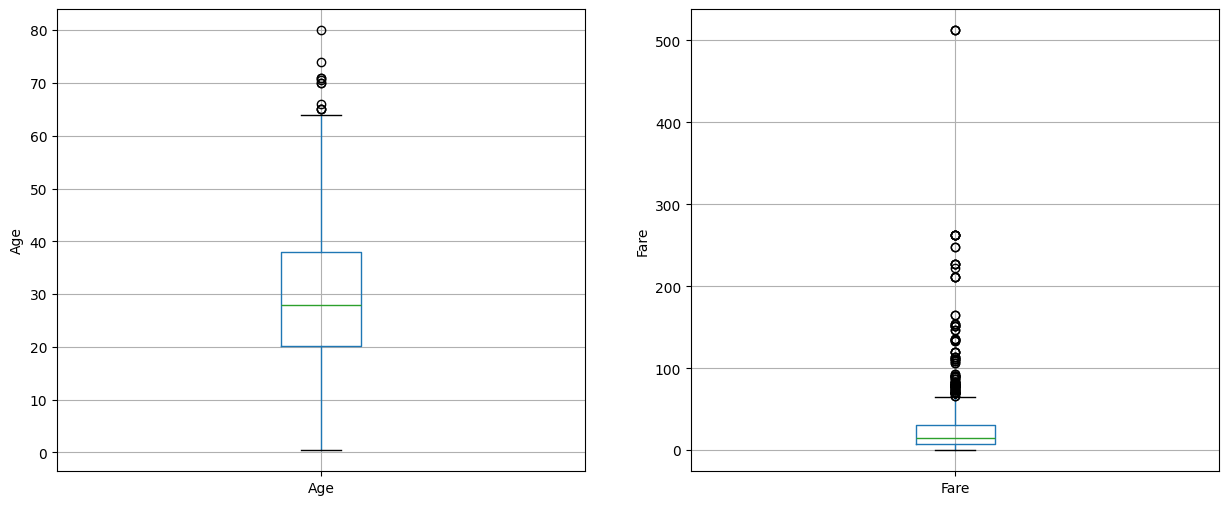

In [16]:
# let's make boxplots to visualise outliers in the continuous variables 
# Age and Fare

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = data.boxplot(column='Age')
fig.set_title('')
fig.set_ylabel('Age')

plt.subplot(1, 2, 2)
fig = data.boxplot(column='Fare')
fig.set_title('')
fig.set_ylabel('Fare')

Text(0.5, 0, 'Fare')

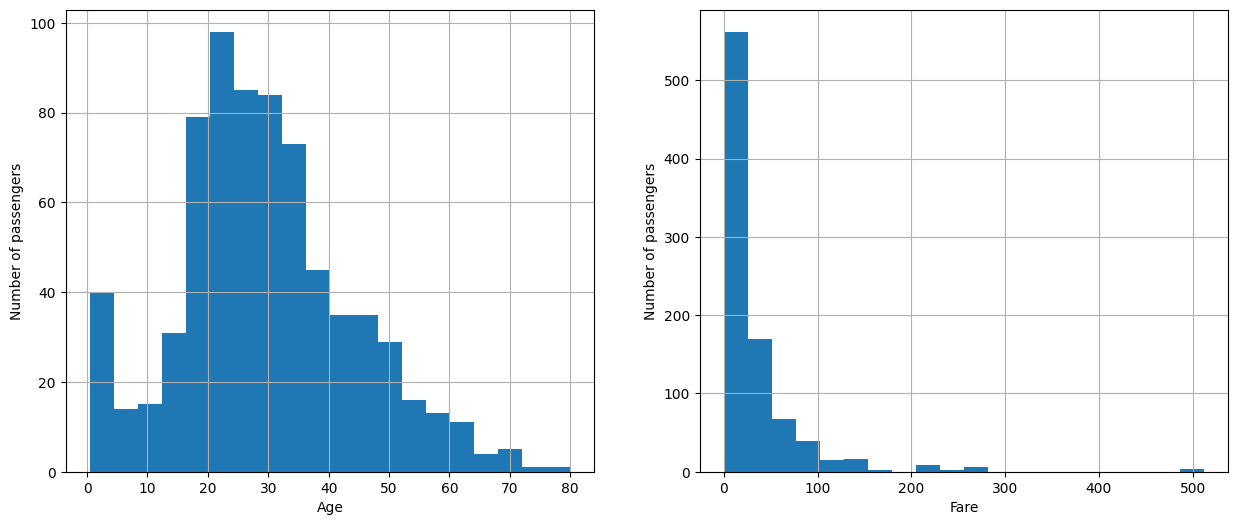

In [17]:
# first we plot the distributions to find out if they are Gaussian or skewed.
# Depending on the distribution, we will use the normal assumption or the interquantile
# range to find outliers

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = data.Age.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Age')

plt.subplot(1, 2, 2)
fig = data.Fare.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel('Fare')

In [18]:
# find outliers

# Age
Upper_boundary = data.Age.mean() + 3* data.Age.std()
Lower_boundary = data.Age.mean() - 3* data.Age.std()
print('Age outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_boundary, upperboundary=Upper_boundary))

# Fare
IQR = data.Fare.quantile(0.75) - data.Fare.quantile(0.25)
Lower_fence = data.Fare.quantile(0.25) - (IQR * 3)
Upper_fence = data.Fare.quantile(0.75) + (IQR * 3)
print('Fare outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Age outliers are values < -13.880374349943303 or > 73.27860964406094
Fare outliers are values < -61.358399999999996 or > 100.2688


In [20]:
# outlies in discrete variables
for var in ['Pclass',  'SibSp', 'Parch']:
    print(data[var].value_counts() / float(len(data)))
    print()

Pclass
3    0.551066
1    0.242424
2    0.206510
Name: count, dtype: float64

SibSp
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: count, dtype: float64

Parch
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: count, dtype: float64



In [21]:
for var in categorical:
    print(var, ' contains ', len(data[var].unique()), ' labels')

Name  contains  891  labels
Sex  contains  2  labels
Ticket  contains  681  labels
Cabin  contains  148  labels
Embarked  contains  4  labels


In [22]:
# Cabin
data['Cabin_numerical'] = data.Cabin.str.extract('(\d+)') # extracts number from string
data['Cabin_numerical'] = data['Cabin_numerical'].astype('float') # parses the above variable to float type

data['Cabin_categorical'] = data['Cabin'].str[0] # captures first letter of string (the letter of the cabin)

# same for submission data
submission['Cabin_numerical'] = submission.Cabin.str.extract('(\d+)')
submission['Cabin_numerical'] = submission['Cabin_numerical'].astype('float')

submission['Cabin_categorical'] = submission['Cabin'].str[0]

data[['Cabin', 'Cabin_numerical', 'Cabin_categorical']].head()

,Cabin,Cabin_numerical,Cabin_categorical
0,NaN,NaN,NaN
1,C85,85.0,C
2,NaN,NaN,NaN
3,C123,123.0,C
4,NaN,NaN,NaN


In [23]:
# drop the original variable
data.drop(labels='Cabin', inplace=True, axis=1)
submission.drop(labels='Cabin', inplace=True, axis=1)

In [24]:
#  Ticket
# extract the last bit of ticket as number
data['Ticket_numerical'] = data.Ticket.apply(lambda s: s.split()[-1])
data['Ticket_numerical'] = np.where(data.Ticket_numerical.str.isdigit(), data.Ticket_numerical, np.nan)
data['Ticket_numerical'] = data['Ticket_numerical'].astype('float')

# extract the first part of ticket as category
data['Ticket_categorical'] = data.Ticket.apply(lambda s: s.split()[0])
data['Ticket_categorical'] = np.where(data.Ticket_categorical.str.isdigit(), np.nan, data.Ticket_categorical)

# submission
submission['Ticket_numerical'] = submission.Ticket.apply(lambda s: s.split()[-1])
submission['Ticket_numerical'] = np.where(submission.Ticket_numerical.str.isdigit(), submission.Ticket_numerical, np.nan)
submission['Ticket_numerical'] = submission['Ticket_numerical'].astype('float')

# extract the first part of ticket as category
submission['Ticket_categorical'] = submission.Ticket.apply(lambda s: s.split()[0])
submission['Ticket_categorical'] = np.where(submission.Ticket_categorical.str.isdigit(), np.nan, submission.Ticket_categorical)

data[['Ticket', 'Ticket_numerical', 'Ticket_categorical']].head()

,Ticket,Ticket_numerical,Ticket_categorical
0,A/5 21171,21171.0,A/5
1,PC 17599,17599.0,PC
2,STON/O2. 3101282,3101282.0,STON/O2.
3,113803,113803.0,NaN
4,373450,373450.0,NaN


In [25]:
# let's explore the ticket categorical part a bit further
data.Ticket_categorical.unique()

array(['A/5', 'PC', 'STON/O2.', nan, 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'LINE', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

In [26]:
# it contains several labels, some of them seem very similar apart from the punctuation
# I will try to reduce this number of labels a bit further

# remove non letter characters from string
text = data.Ticket_categorical.apply(lambda x: re.sub("[^a-zA-Z]", '', str(x)))

# to visualise the output and compare with input
pd.concat([text, data.Ticket_categorical], axis=1)

,Ticket_categorical,Ticket_categorical
0,A,A/5
1,PC,PC
2,STONO,STON/O2.
3,nan,NaN
4,nan,NaN
...,...,...
886,nan,NaN
887,nan,NaN
888,WC,W./C.
889,nan,NaN


In [27]:
# set to upper case: we reduce the number of labels quite a bit
text = text.str.upper()
text.unique()


# process the variable in submission as well
data['Ticket_categorical'] = text

submission['Ticket_categorical'] = submission.Ticket_categorical.apply(lambda x: re.sub("[^a-zA-Z]", '', str(x)))
submission['Ticket_categorical'] = submission['Ticket_categorical'].str.upper()


# drop the original variable
data.drop(labels='Ticket', inplace=True, axis=1)
submission.drop(labels='Ticket', inplace=True, axis=1)